In [1]:
import numpy as np

# Matrix Product State Generative Model

### Prep datasets

In [2]:
# parse text files

year_range = [1880, 2022] # Include years in this range, inclusive

female_names = []
male_names = []
female_counts = []
male_counts = []
vocabulary = set()
max_length = 0
for year in range(year_range[0], year_range[1] + 1):
    with open(f'names/yob{year}.txt', 'r') as f:
        for line in f:
            name, gender, count = line.split(',')
            name = name.lower()
            count = int(count)
            max_length = max(max_length, len(name))
            if gender == 'F':
                female_names.append(name)
                female_counts.append(count)
                for i in range(len(name)):
                    vocabulary.add(name[i])
            elif gender == 'M':
                male_names.append(name)
                male_counts.append(count)
                for i in range(len(name)):
                    vocabulary.add(name[i])
            else:
                print(f'Name {name} with gender {gender} is not counted')

female_counts = np.array(female_counts)
male_counts = np.array(male_counts)

for i, name in enumerate(female_names):
    female_names[i] = name.ljust(max_length, '_')
for i, name in enumerate(male_names):
    male_names[i] = name.ljust(max_length, '_')
vocabulary.add('_')

vocabulary = sorted(list(vocabulary))
vocab_size = len(vocabulary)

# tokenize
map_char_to_int = {char: i for i, char in enumerate(vocabulary)}
female_tokens = np.array([[map_char_to_int[char] for char in name] for name in female_names])
male_tokens = np.array([[map_char_to_int[char] for char in name] for name in male_names])

### Initialize MPS model

In [38]:
from matrix_product_state import MatrixProductState

from importlib import reload
import matrix_product_state
reload(matrix_product_state)
from matrix_product_state import MatrixProductState


# initialize MPS
num_tensors = max_length
site_dims = [vocab_size]*max_length
mps = MatrixProductState(max_length, site_dims)


# test train split
test_frac = 0.2
num_points = female_tokens.shape[0]
inds = np.random.permutation(female_tokens.shape[0])
inds_train = inds[int(test_frac*num_points):]
inds_test = inds[:int(test_frac*num_points)]

# sample training data
n_train = 10000
probs = female_counts[inds_train]/np.sum(female_counts[inds_train])
inds = np.random.choice(inds_train, p=probs, size=n_train)
X_train = female_tokens[inds]

# sample test data
n_test = 1000
probs = female_counts[inds_test]/np.sum(female_counts[inds_test])
inds = np.random.choice(inds_test, p=probs, size=n_test)
X_test = female_tokens[inds]

# load data
mps.load_data(X_train, dataset_name='train')
mps.load_data(X_test, dataset_name='test')


Play around with model parameters by setting the attributes `mps.cutoff` and `mps.max_rank`

In [39]:
mps.cutoff = 1e-3
mps.max_rank = 50

### Train

Play around with training parameters by setting the attributes `mps.batch_size` and `mps.learning_rate`

In [40]:
mps.batch_size = 10000
mps.learning_rate = 1e-4

mps.verbose = 1
mps.train(num_sweeps=10)

Finished sweep 0. Sweep direction: left
Ranks: [5, 4, 3, 23, 10, 33, 23, 17, 8, 2, 3, 2, 2, 3]
Losses: {'train': 131.56171893130787, 'test': 131.0629168998878}


/home/johngardiner/projects/name-generator/matrix_product_state.py:244: RuntimeWarning: overflow encountered in divide
  mats = -2*np.einsum('ij,i,ki->jik', left_environment, 1/amplitudes, right_environment)
/home/johngardiner/projects/name-generator/matrix_product_state.py:256: RuntimeWarning: invalid value encountered in divide
  self.merged_tensor /= np.sum(self.merged_tensor**2)**0.5 # keep the merged tensor (and hence the whole MPS) normed to 1


ValueError: Merged tensor contains NaN

Plot losses

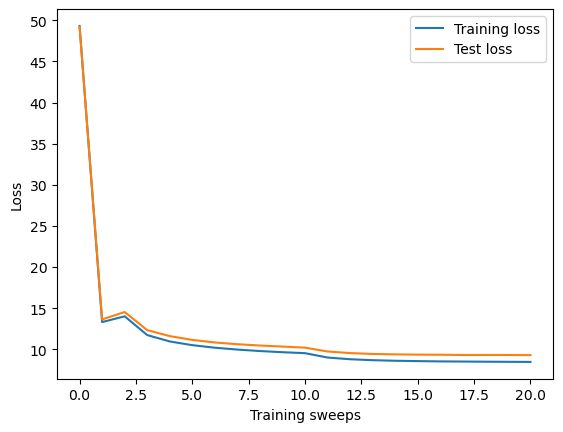

In [28]:
import matplotlib.pyplot as plt

# plt.plot(np.log(np.arange(len(mps.losses['train']))), np.log(mps.losses['train']))
# plt.plot(np.log(np.arange(len(mps.losses['test']))), np.log(mps.losses['test']))
plt.plot(mps.losses['train'], label='Training loss')
plt.plot(mps.losses['test'], label='Test loss')
plt.legend()
plt.xlabel('Training sweeps')
plt.ylabel('Loss')
plt.show()

### Sample

In [29]:
# sample tokens from model
samples = mps.sample(num_samples=1000)

# change from tokens back to characters
def untokenize(tokens):
    split_names = np.array(vocabulary)[tokens]
    names = []
    for name in split_names:
        names.append(''.join(name))
    return names

sampled_names = untokenize(samples)


Check quality

In [30]:

female_name_set = set(female_names)
train_name_set = set(untokenize(X_train))
not_in_training = []
not_in_dataset = []
for name in sampled_names:
    if name not in female_name_set:
        not_in_dataset.append(name)
    if name not in train_name_set:
        not_in_training.append(name)

num_samples = samples.shape[0]
print(f'{len(not_in_training)}/{num_samples} names not in training data')
print(f'{len(not_in_dataset)}/{num_samples} names not in full dataset')

print('\nSome names not in the training dataset:')
random_names = np.random.choice(not_in_training, 10, replace=False)
for name in random_names:
    print(f'\t{name}')

print('\nSome names not in the full dataset:')
random_names = np.random.choice(not_in_dataset, 10, replace=False)
for name in random_names:
    print(f'\t{name}')

594/1000 names not in training data
453/1000 names not in full dataset

Some names not in the training dataset:
	sharl__________
	tayetta________
	bever__________
	mahela_________
	kimee__________
	jimine_________
	joruer_________
	ambrie_________
	anura__________
	astricia_______

Some names not in the full dataset:
	joycdy_________
	virge__________
	monale_________
	therson________
	barona_________
	andrgia________
	donith_________
	dortte_________
	annnie_________
	akene__________


# Ensemble of MPSs

In [49]:
from importlib import reload
import matrix_product_state
reload(matrix_product_state)
from matrix_product_state import MPSForest


# initialize MPS
num_models = 2
num_tensors = max_length
site_dims = [vocab_size]*max_length
mps = MPSForest(num_models, max_length, site_dims)


# test train split
test_frac = 0.2
num_points = female_tokens.shape[0]
inds = np.random.permutation(female_tokens.shape[0])
inds_train = inds[int(test_frac*num_points):]
inds_test = inds[:int(test_frac*num_points)]

# sample training data
n_train = 10000
probs = female_counts[inds_train]/np.sum(female_counts[inds_train])
inds = np.random.choice(inds_train, p=probs, size=n_train)
X_train = female_tokens[inds]

# sample test data
n_test = 1000
probs = female_counts[inds_test]/np.sum(female_counts[inds_test])
inds = np.random.choice(inds_test, p=probs, size=n_test)
X_test = female_tokens[inds]

# load data
mps.load_data(X_train, dataset_name='train')
mps.load_data(X_test, dataset_name='test')

# model hyperparameters
mps.cutoff = 1e-3
mps.max_rank = 10

# training parameters
mps.batch_size = 10000
mps.learning_rate = 1e-7

# train
mps.verbose = 1
mps.train(num_sweeps=50)

Finished sweep 0. Sweep direction: left
Ranks: [10, 10, 10, 10, 10, 10, 10, 6, 3, 3, 3, 3, 3, 3]
Losses: {'train': 17.859319271575792, 'test': 19.447253051137317}
Finished sweep 1. Sweep direction: right
Ranks: [10, 10, 10, 10, 10, 10, 10, 10, 8, 3, 3, 3, 3, 3]
Losses: {'train': 16.82035376852237, 'test': 18.529420480700086}
Finished sweep 2. Sweep direction: left
Ranks: [10, 10, 10, 10, 10, 10, 10, 10, 8, 3, 3, 3, 3, 3]
Losses: {'train': 16.306297199178804, 'test': 17.98771875729577}
Finished sweep 3. Sweep direction: right
Ranks: [10, 10, 10, 10, 10, 10, 10, 10, 8, 3, 3, 3, 3, 3]
Losses: {'train': 15.924846084360537, 'test': 17.630490981009054}
Finished sweep 4. Sweep direction: left
Ranks: [10, 10, 10, 10, 10, 10, 10, 10, 8, 3, 3, 3, 3, 3]
Losses: {'train': 15.63732475249215, 'test': 17.356812827930174}
Finished sweep 5. Sweep direction: right
Ranks: [10, 10, 10, 10, 10, 10, 10, 10, 8, 3, 3, 3, 3, 3]
Losses: {'train': 15.395121058719932, 'test': 17.12954210674476}
Finished sweep 6. 

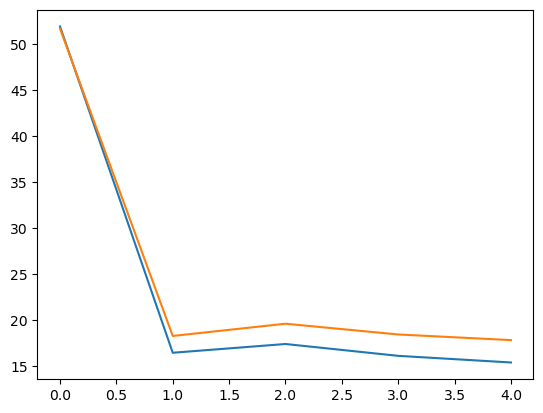

In [48]:
import matplotlib.pyplot as plt

# plt.plot(np.log(np.arange(len(mps.losses['train']))), np.log(mps.losses['train']))
# plt.plot(np.log(np.arange(len(mps.losses['test']))), np.log(mps.losses['test']))
plt.plot(mps.losses['train'])
plt.plot(mps.losses['test'])
plt.show()

In [46]:
# sample tokens from model
samples = mps.sample(num_samples=1000)

# change from tokens back to characters
def untokenize(tokens):
    split_names = np.array(vocabulary)[tokens]
    names = []
    for name in split_names:
        names.append(''.join(name))
    return names

sampled_names = untokenize(samples)



female_name_set = set(female_names)
train_name_set = set(untokenize(X_train))
not_in_training = []
not_in_dataset = []
for name in sampled_names:
    if name not in female_name_set:
        not_in_dataset.append(name)
    if name not in train_name_set:
        not_in_training.append(name)

num_samples = samples.shape[0]
print(f'{len(not_in_training)}/{num_samples} names not in training data')
print(f'{len(not_in_dataset)}/{num_samples} names not in full dataset')

print('\nSome names not in the training dataset:')
random_names = np.random.choice(not_in_training, 10, replace=False)
for name in random_names:
    print(f'\t{name}')

print('\nSome names not in the full dataset:')
random_names = np.random.choice(not_in_dataset, 10, replace=False)
for name in random_names:
    print(f'\t{name}')


961/1000 names not in training data
880/1000 names not in full dataset

Some names not in the training dataset:
	ressy__________
	scie___________
	meli___________
	madtyi_________
	arelee_________
	lenrann________
	wiilon_________
	bruina_________
	malian_________
	althelia_______

Some names not in the full dataset:
	isola__________
	pie____________
	lazine_________
	rakleee________
	eryrale________
	ilbna__________
	bdeys__________
	palolie________
	elarta_________
	xaba___________
